realfake_vidhub_16x9.avif

# The Aim of the project is to identify  Fake & Real news  using Natural Language Processing.

## Problem Statement: 

* The problem at hand is **to develop an effective and reliable system for detecting real or fake news using Natural Language Processing (NLP) techniques**. Given the exponential growth of online content and the increasing spread of misinformation, it has become crucial to **distinguish between trustworthy and deceptive news sources**. This problem statement aims to **address the challenge of accurately identifying and classifying news articles or information as genuine or fabricated, utilizing advanced NLP algorithms and methodologies**.

* The proposed system should be capable of **analyzing the textual content of news articles**, considering various linguistic and contextual features, and assessing their credibility and authenticity. It should be able to **differentiate between accurate, fact-based reporting and deceptive, misleading information by leveraging techniques such as text classification, sentiment analysis, semantic understanding, and linguistic pattern recognition**.

* Ultimately, the **goal is to develop an NLP-based solution that aids users, media organizations, and fact-checkers in distinguishing between genuine and fabricated news, contributing to the fight against misinformation and promoting trustworthy sources of information in the digital landscape**.

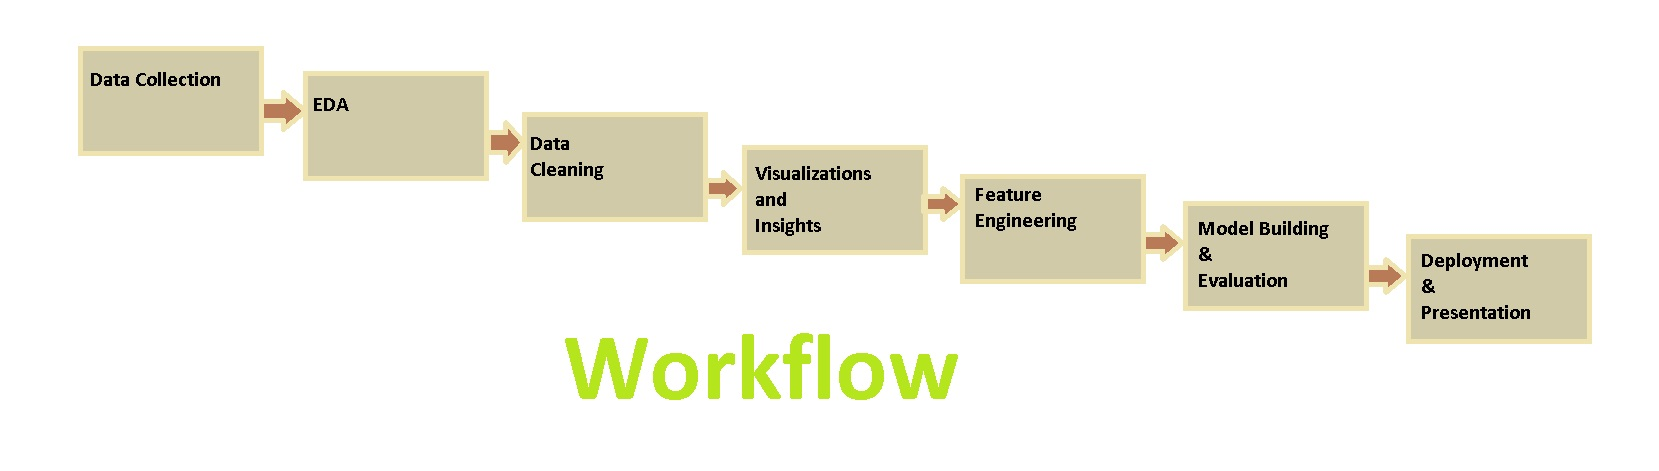

## Importing Basic Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import re
import string
from nltk.corpus import stopwords
import nltk
from string import punctuation
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer

#models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

## Step 1 Data Collection 
##### In this step we are extracting data from two csv Files One for Fake news and one for Real news

In [2]:
# Increasing the width of the the columns
# pd.set_option('display.max_colwidth', None)

In [112]:
# Loading Both News dataset
# fake_news
fake=pd.read_csv('../Fake.csv',encoding = 'latin-1')
fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [113]:
# Real_news
real=pd.read_csv('../True.csv',encoding='latin-1',on_bad_lines='skip')
real.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


## Step 2 Exploratary Data Analysis 

#### We will browse through the data and collect some valuable insights with the help of Tables and Visual Plots 

In [114]:
# checking shapes
print(fake.shape)
real.shape

(23481, 4)


(21416, 4)

In [115]:
print(fake.info())
print('-------------------------')
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21416 entries, 0 to 21415
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21416 non-null  object
 1   text     21416 non-null  object
 2   subject  21416 non-null  object
 3   date     21416 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [116]:
# converting fake datatype of date column 
fake['date']=pd.to_datetime(fake['date'],errors='coerce')
# converting real datatype of date column 
real['date']=pd.to_datetime(real['date'],errors='coerce')

In [117]:
print(fake.date.dtype)
print(real.date.dtype)

datetime64[ns]
datetime64[ns]


In [118]:
# checking duplicate rows for fake news
print(fake.duplicated().sum())
# checking duplicate rows for real news
real.duplicated().sum()

3


206

In [119]:
fake=fake.drop_duplicates()
real=real.drop_duplicates()
print(fake.duplicated().sum())
real.duplicated().sum()

0


0

In [120]:
# Missing values
print(fake.isnull().sum())
print('-------------------------')
real.isnull().sum()

title       0
text        0
subject     0
date       10
dtype: int64
-------------------------


title      0
text       0
subject    0
date       0
dtype: int64

### Observation:
#### There are 35 rows in the fake news dataset with the date labeled as "Nat," indicating invalid or missing date entries.

In [121]:
# Creating new dataFrame with all null values of date
nan_date= fake[fake['date'].isnull()]
print(nan_date.shape)
nan_date.head()

(10, 4)


,title,text,subject,date
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT


In [122]:
nan_date['subject'].value_counts()

politics           5
left-news          3
Government News    2
Name: subject, dtype: int64

##### Observation:
It seems that dates containing with null value are all from fake news with political background only..

In [123]:
# Dropping null values
fake=fake.dropna()
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [124]:
# checking if there are any blank text in text column
fake[fake['text']==' '].head(20)

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,2017-05-10
11041,Joe Scarborough BERATES Mika Brzezinski Over ...,,politics,2017-04-26
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,2017-04-06
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,2017-04-02
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,2017-04-01
11241,BOOM! SEAN SPICER: Trump Sold Hotels In Russi...,,politics,2017-03-31
11247,MICHAEL FLYNNS LAWYER Releases Statement Scor...,,politics,2017-03-30
11249,ROB SCHNEIDER Nails The Russia Conspiracy Theo...,,politics,2017-03-30
11267,TREY GOWDY ON SPYING ON AMERICAN CITIZENS&Like...,,politics,2017-03-28
11268,SEAN SPICER CALLS OUT Race Baiting Journalist:...,,politics,2017-03-28


##### Observations:
 With blank descriptions 626 are identified as fake news

In [125]:
blank_text=fake[fake['text']==' ']

In [126]:
# checking if there are any blank text in text column
real[real['text']==' ']

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,2016-06-16


##### Observations: 
 * wherever there is blank text in the text column, the title column contains information about "Video" or "Poll"
 

In [127]:
# Remove rows with blank text in the 'text' column
fake = fake[fake['text'] != ' ']
real = real[real['text'] != ' ']
print(fake[fake['text']==' '])
real[real['text']==' ']

Empty DataFrame
Columns: [title, text, subject, date]
Index: []


,title,text,subject,date


In [128]:
print(fake.shape)
real.shape

(22842, 4)


(21209, 4)

## Step 3 Date visualizations

### subject column 

In [129]:
fake['subject'].value_counts()

News               9050
politics           6427
left-news          4307
Government News    1497
US_News             783
Middle-east         778
Name: subject, dtype: int64

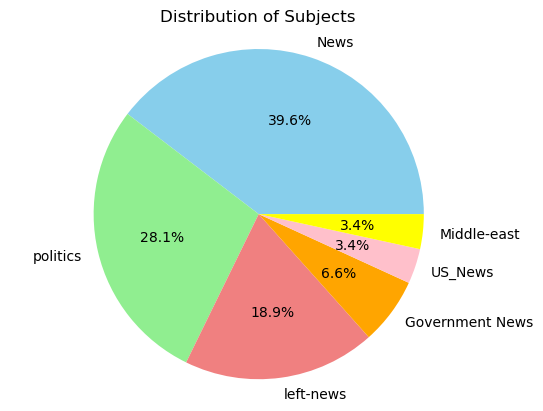

In [130]:
# analysing subject column of fake news

# Create a pie chart
# Define colors for the pie slices
colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'pink','yellow']
subject_count = fake['subject'].value_counts()
subject_labels = subject_count.index.tolist()

# Create the pie chart with percentage labels
plt.pie(subject_count, labels=subject_labels, colors=colors, autopct='%1.1f%%')
# Set aspect ratio to make the pie chart circular
plt.axis('equal')
# Set a title for the pie chart
plt.title('Distribution of Subjects')
# Display the chart
plt.show()

 #### Observations:
 * Fake news has five subjects in which 'news' subject has high rate of publishing fake news
 and possibility of publishing fake news from US news & middle east are too low.

In [131]:
real['subject'].value_counts()

politicsNews    11218
worldnews        9991
Name: subject, dtype: int64

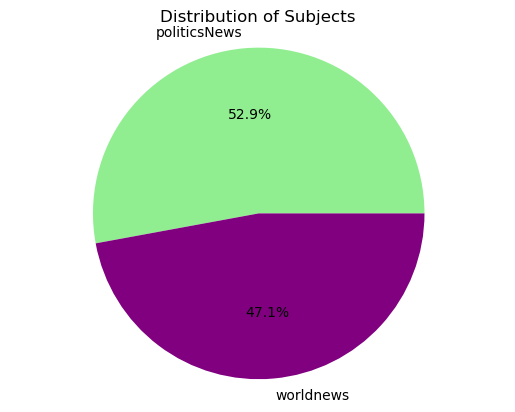

In [132]:
# analysing subject column of real news

# Create a pie chart
# Define colors for the pie slices
colors = ['lightgreen', 'purple']
subject_count = real['subject'].value_counts()
subject_labels = subject_count.index.tolist()

# Create the pie chart with percentage labels
plt.pie(subject_count, labels=subject_labels, colors=colors, autopct='%1.1f%%')
# Set aspect ratio to make the pie chart circular
plt.axis('equal')
# Set a title for the pie chart
plt.title('Distribution of Subjects')
# Display the chart
plt.show()

#### Observations:
* By comparing fake & real news subjects,we can conclude that the news related to worldnews subjects were real news.

* Real news articles on 'politics' topic are more than fake news articles.
##### so we can say that this feature is important but we cant use this feature for model building as categories in both subject columns are not same i.e it is not one on one mapping..so we will drop this column

 ### Date column 

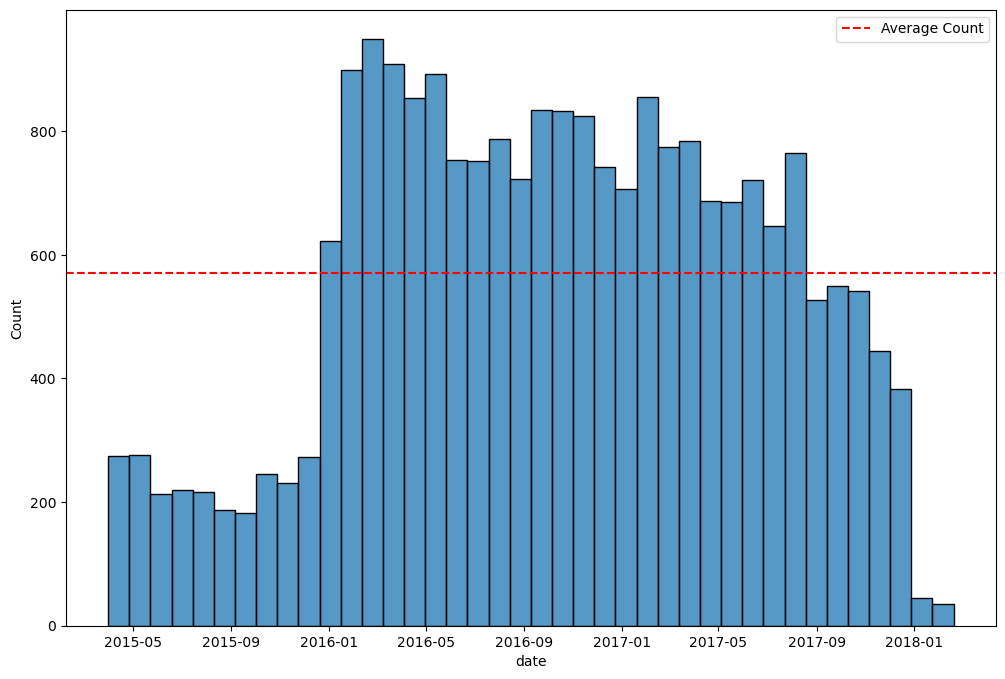

In [133]:
# Analysing Date column of fake news
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=fake, x="date")
# Calculate the average value for the count
bin_heights, bin_edges, _ = ax.hist(fake["date"], bins='auto', alpha=0)
average_value = np.mean(bin_heights)
plt.axhline(y=average_value, color='red', linestyle='--', label='Average Count')
plt.legend()
plt.show()

### Observations:
#### average of fake news counts are around 600 per Month

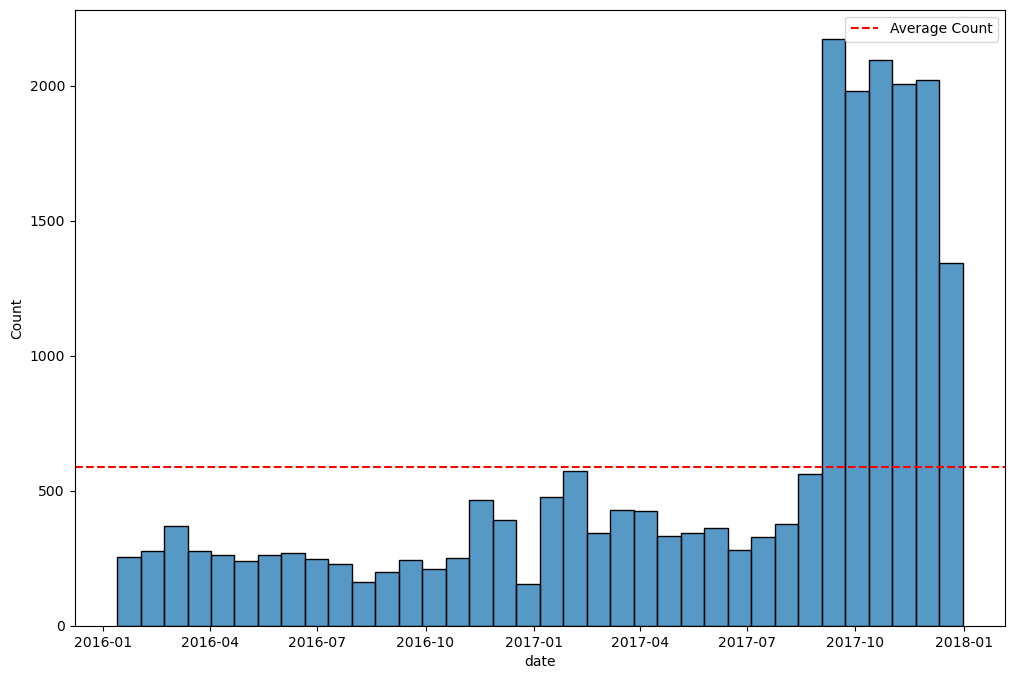

In [134]:
# Analysing Date column of real news
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=real, x="date")
# Calculate the average value for the count
bin_heights, bin_edges, _ = ax.hist(real["date"], bins='auto', alpha=0)
average_value = np.mean(bin_heights)
# Add the average value line
plt.axhline(y=average_value, color='red', linestyle='--', label='Average Count')
plt.legend()
plt.show()

##### Observations:
* From above graph we can say that in october,november & december month releasing real news rates were very high and average of real news counts are around 600 per month.

* By comparing fake and real news Date column ,news release at end of year were real news.
* But we cant interprete insights from date column of fake news..its need to be further analysis.

In [135]:
# Creating target column
real['Class']='True'
fake['Class']='Fake'

In [136]:
# concanating two dataframes
df=pd.concat([real,fake])
df.reset_index(inplace=True)
df.shape

(44051, 6)

In [137]:
# Extracting month and year from date column
df['Month'] = df['date'].dt.strftime('%B')
df['Year'] = df['date'].dt.year
df.head()

,index,title,text,subject,date,Class,Month,Year
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,True,December,2017
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,True,December,2017
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,True,December,2017
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,True,December,2017
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,True,December,2017


In [138]:
# Monthwise news count
pd.crosstab(df['Class'],df['Month'])

Month,April,August,December,February,January,July,June,March,May,November,October,September
Class,,,,,,,,,,,,
Fake,2082,1905,1583,1878,2033,1949,1914,2044,2138,1695,1893,1728
True,911,916,2838,1017,995,875,972,1168,898,3716,3491,3412


### Observations:
#### count of fake new in month of January,April,May,June,July,August..i.e in the middle year rate of publishing fake news was maximum

In [139]:
# Yearwise news count
pd.crosstab(df['Class'],df['Year'])

Year,2015,2016,2017,2018
Class,,,,
Fake,2417,11443,8947,35
True,0,4699,16510,0


<AxesSubplot:xlabel='Class'>

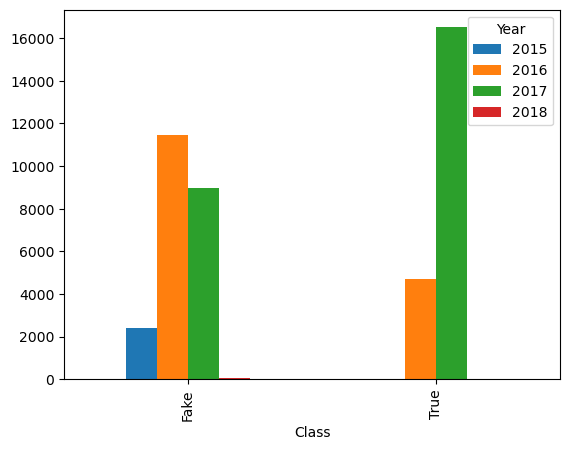

In [140]:
pd.crosstab(df['Class'],df['Year']).plot(kind='bar')

### Observations:
#### The year 2016 saw a higher percentage of fake news articles, with around 11,000 fake news articles and only 4,700 true news articles. In contrast, the year 2017 had 9,000 fake news articles and 16,500 true news articles.

In [141]:
# 2016 news analysis-As it has maximum fake news
df_2016= df[df['Year']==2016]
df_2016.shape

(16142, 8)

In [142]:
# Month analysis wrt class in 2016
a=pd.crosstab(df_2016['Month'],df_2016['Class'])
b= pd.DataFrame(a)

In [143]:
# calculating % difference
b['Percentage_fake']=round((b['Fake']/b['True'])*100)
b

Class,Fake,True,Percentage_fake
Month,,,
April,975,383,255.0
August,891,265,336.0
December,836,422,198.0
February,1018,428,238.0
January,1081,245,441.0
July,882,337,262.0
June,868,417,208.0
March,1085,489,222.0
May,1011,394,257.0


<AxesSubplot:xlabel='Month'>

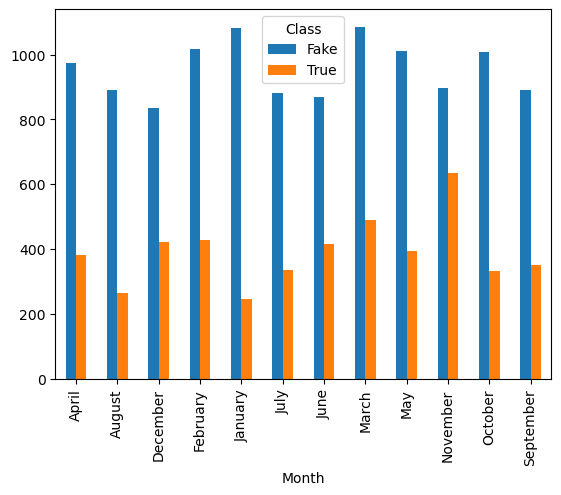

In [144]:
# crosstab visualization for month column in 2016
pd.crosstab(df_2016['Month'],df_2016['Class']).plot(kind='bar')

### Title column 

In [145]:
fake['title_length'] = fake['title'].apply(len)     #word count
average_title_length = fake['title_length'].mean()
average_title_length

94.21942036599248

In [146]:
real['title_length'] = real['title'].apply(len)
average_title_length_r = real['title_length'].mean()
average_title_length_r

64.66019142816728

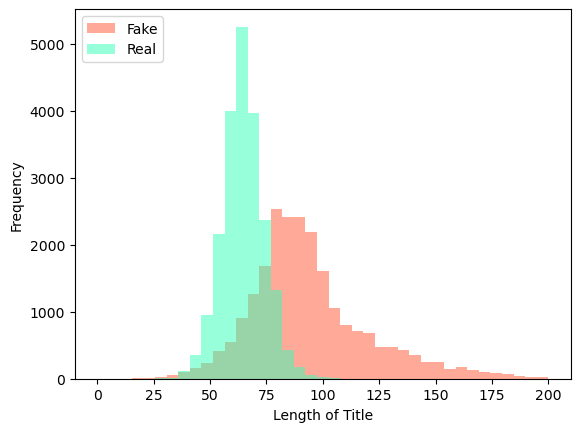

In [147]:
# word count of title column

# Define the bins for the histograms      
bins = np.linspace(0, 200, 40)         #to create 40 equally spaced bins between 0 and 200.

# Plot the histogram for the "length_title" column in the fake DataFrame
plt.hist(fake["title_length"], bins=bins, alpha=0.5, label="Fake", color="#FF5733")
# Plot the histogram for the "length_title" column in the real DataFrame
plt.hist(real["title_length"], bins=bins, alpha=0.5, label="Real", color="#33FFB8")

# Add labels to the x-axis and y-axis
plt.xlabel("Length of Title")
plt.ylabel("Frequency")
# Add a legend to the plot
plt.legend(loc="upper left")
# Show the plot
plt.show()

### Observations:

* Real news titles tend to have shorter lengths, primarily up to 100 characters, while fake news titles can be longer, reaching up to 200 characters.

* The "length of title" can be considered as a potentially important feature for model building, as it appears to show some differences between real and fake news. The fact that real news titles are generally shorter could be a useful characteristic for classification purposes.

** Reuters word analysis **

In [148]:
# for real
rows_con_reuters = real[real['text'].str.contains('Reuters')]
rows_con_reuters.shape

(21171, 6)

In [149]:
# for fake
rows_con_reuters_f = fake[fake['text'].str.contains('Reuters')]
rows_con_reuters_f.shape

(311, 6)

In [150]:
df_Reuters=df[df['text'].str.contains('Reuters',case=False)]
df_Reuters

,index,title,text,subject,date,Class,Month,Year
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,True,December,2017
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,True,December,2017
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,True,December,2017
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,True,December,2017
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,True,December,2017
...,...,...,...,...,...,...,...,...
43845,23275,False Alarm or Psy-Op? LAX Active Shooter Sp...,Shawn Helton 21st Century WireAnother active-s...,Middle-east,2016-09-03,Fake,September,2016
43878,23308,DALLAS MAIDAN: Staged Snipers Designed to Infl...,"Daily Shooter 21st Century WireLast night, a h...",Middle-east,2016-07-08,Fake,July,2016
43914,23344,Peace Prize President Obama Approved $200 Bill...,21st Century Wire says The military industrial...,Middle-east,2016-05-24,Fake,May,2016
43929,23359,To Stop Clinton: The TOP Reason Americans Wi...,21st Century Wire says A greater percentage of...,Middle-east,2016-05-06,Fake,May,2016


In [151]:
#percentage of reuters words in text column

reuters_per=len(df_Reuters)/len(df)*100
reuters_per

48.79117386665456

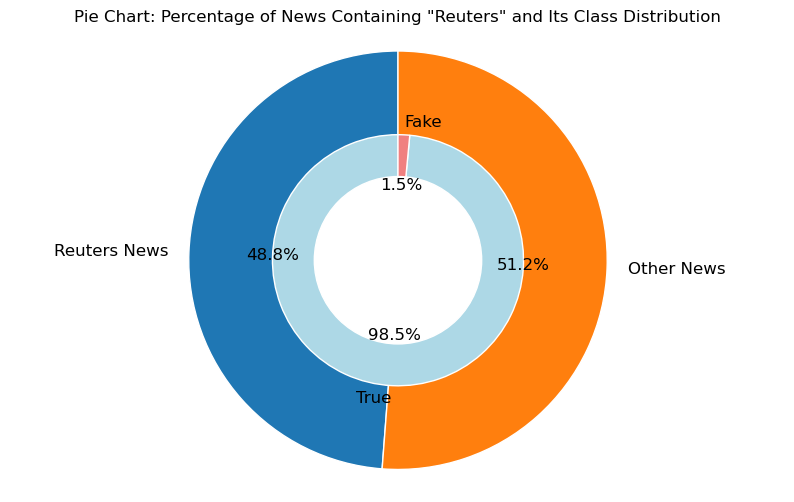

In [152]:
# Calculate the percentage of rows containing "Reuters" out of the total news
percentage_reuters = (len(df_Reuters) / len(df)) * 100

# Count the occurrences of each unique value in the 'class' column in the filtered DataFrame
class_counts = df_Reuters['Class'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 6))

# Outer pie chart for "Reuters News" and "Other News"
plt.pie([percentage_reuters, 100 - percentage_reuters], labels=['Reuters News', 'Other News'], autopct='%1.1f%%',startangle=90, textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'white'})

# Inner pie chart for 'class' distribution within "Reuters News" sector
ax = plt.gca()  # Get the current axis
ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', radius=0.6, colors=['lightblue', 'lightcoral'],startangle=90, textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'white'})

# Draw a white circle at the center to make it look like a donut chart
ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

plt.title('Pie Chart: Percentage of News Containing "Reuters" and Its Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

### Observations:
The word "Reuters," which is a well-known US news agency, is commonly found in the real news dataset, appearing in 21,171 out of 21,210 rows. In contrast, it appears only 308 times out of 23,447 rows in the fake news dataset.
#### This is important feature for identifying real and fake news.

#### URL

In [153]:
url_pattern = r'https?://(?:www\.)?\S+'

In [154]:
url_pattern = r'https?://\S+'

In [155]:
# Function to find links in text and return zero if no links are found
def find_links(text):
    links = re.findall(url_pattern, str(text))
    return len(links) if links else 0


In [156]:
# Apply the function to the 'text' column and create the 'links' column
fake['links_count'] = fake['text'].apply(find_links)
# Apply the function to the 'text' column and create the 'links' column
real['links_count'] = real['text'].apply(find_links)# Function to find links in text and return 1 if links are found, otherwise return 
fake.head(5)

,title,text,subject,date,Class,title_length,links_count
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,Fake,79,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,Fake,69,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,Fake,90,1
3,Trump Is So Obsessed He Even Has Obamas Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,Fake,78,4
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,Fake,70,0


In [157]:
len(fake[fake['links_count']>=1])/len(fake)


0.1439891428071097

### Observations:

#### As % of url present in fake dataset is 14% & in real news it is zero ,so it will be important feature to identify real and fake news.

#### Text column 

# Text Processing

* Converting into Lower case

In [54]:
fake['text']=fake['text'].str.lower()
real['text']=real['text'].str.lower()
print(fake.head(2))
real.head(2)

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject       date Class  \
0  donald trump just couldn t wish all americans ...    News 2017-12-31  Fake   
1  house intelligence committee chairman devin nu...    News 2017-12-31  Fake   

   title_length  links_count  
0            79            0  
1            69            0  


,title,text,subject,date,Class,title_length,links_count
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,2017-12-31,True,64,0
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,2017-12-29,True,64,0


### Removing other unwanted Pattern

In [55]:
def clean_text(text):
    text = re.sub('@[\w]*', '', text)         # @
    text = re.sub("[0-9" "]+", '',text)       # no's
    text = re.sub('[‘’“”…]', '', text)       
    text = re.sub("\s+[a-z]\s+", " ",text)   #  a b c-----single letter
    text = re.sub("\W", " ", text)           #	*-+=)
    #text = re.sub('http[^\s]+', '',text)
    return text

clean = lambda x: clean_text(x)

fake["clean_text"] = fake["text"].apply(clean_text) # Clean The Text
real["clean_text"] = real["text"].apply(clean_text)

### Tokenization ,Stamming ,Removing stopwords & punctuation

           -stemming-word is converted into its non-changing portions.
           -lammitization-it maintain dictionary word form

In [56]:
# for fake dataset

# Tokenize
fake['tokenized_text'] = [nltk.word_tokenize(x) for x in fake['clean_text']]

# list of Stopwords & punctuations
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['getti','pic','www','featur','featured','image','subscrib','becom','captur','wire','say','imag','video','screen','via','st','com','said','show','may','ask','one say','even','make']
# Removing stopword & punctuations 
fake['tokenized_text'] = fake['tokenized_text'].apply(lambda row: [word for word in row if word not in stop_words])

#lemmatizer = WordNetLemmatizer()
#fake_news['lemma_text'] = fake_news['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
#fake_news['lemma_text'] = fake_news['lemma_text'].apply(lambda x: ' '.join(x))
#fake_news.head()

# stemming words
stemmer = PorterStemmer()
fake['stem_text'] = fake['tokenized_text'].apply(lambda x: [stemmer.stem(i) for i in x])
fake['stem_text'] = fake['stem_text'].apply(lambda x: ' '.join(x))
fake.head()

,title,text,subject,date,Class,title_length,links_count,clean_text,tokenized_text,stem_text
0,Donald Trump Sends Out Embarrassing New Year...,donald trump just couldn t wish all americans ...,News,2017-12-31,Fake,79,0,donald trump just couldn wish all americans ha...,"[donald, trump, wish, americans, happy, new, y...",donald trump wish american happi new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,2017-12-31,Fake,69,0,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",hous intellig committe chairman devin nune go ...
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,2017-12-30,Fake,90,1,on friday it was revealed that former milwauk...,"[friday, revealed, former, milwaukee, sheriff,...",friday reveal former milwauke sheriff david cl...
3,Trump Is So Obsessed He Even Has Obamas Name...,"on christmas day, donald trump announced that ...",News,2017-12-29,Fake,78,4,on christmas day donald trump announced that ...,"[christmas, day, donald, trump, announced, wou...",christma day donald trump announc would back w...
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,2017-12-25,Fake,70,0,pope francis used his annual christmas day mes...,"[pope, francis, used, annual, christmas, day, ...",pope franci use annual christma day messag reb...


In [57]:
# for real dataset

# tokenize
real['tokenized_text'] = [nltk.word_tokenize(x) for x in real['clean_text']]

# Stopwords & punctuations
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['said','one','includ','say']
# stopword removal
real['tokenized_text'] = real['tokenized_text'].apply(lambda row: [word for word in row if word not in stop_words])

# stemming words
stemmer = PorterStemmer()
real['stem_text'] = real['tokenized_text'].apply(lambda x: [stemmer.stem(i) for i in x])
real['stem_text'] = real['stem_text'].apply(lambda x: ' '.join(x))
real.head()

,title,text,subject,date,Class,title_length,links_count,clean_text,tokenized_text,stem_text
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,2017-12-31,True,64,0,washington reuters the head of conservativ...,"[washington, reuters, head, conservative, repu...",washington reuter head conserv republican fact...
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,2017-12-29,True,64,0,washington reuters transgender people will...,"[washington, reuters, transgender, people, all...",washington reuter transgend peopl allow first ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington (reuters) - the special counsel inv...,politicsNews,2017-12-31,True,60,0,washington reuters the special counsel inv...,"[washington, reuters, special, counsel, invest...",washington reuter special counsel investig lin...
3,FBI Russia probe helped by Australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsNews,2017-12-30,True,59,0,washington reuters trump campaign adviser ...,"[washington, reuters, trump, campaign, adviser...",washington reuter trump campaign advis georg p...
4,Trump wants Postal Service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsNews,2017-12-29,True,69,0,seattle washington reuters president donal...,"[seattle, washington, reuters, president, dona...",seattl washington reuter presid donald trump c...


### Wordcloud 
     -Word clouds visualize the most frequently occurring words in a text

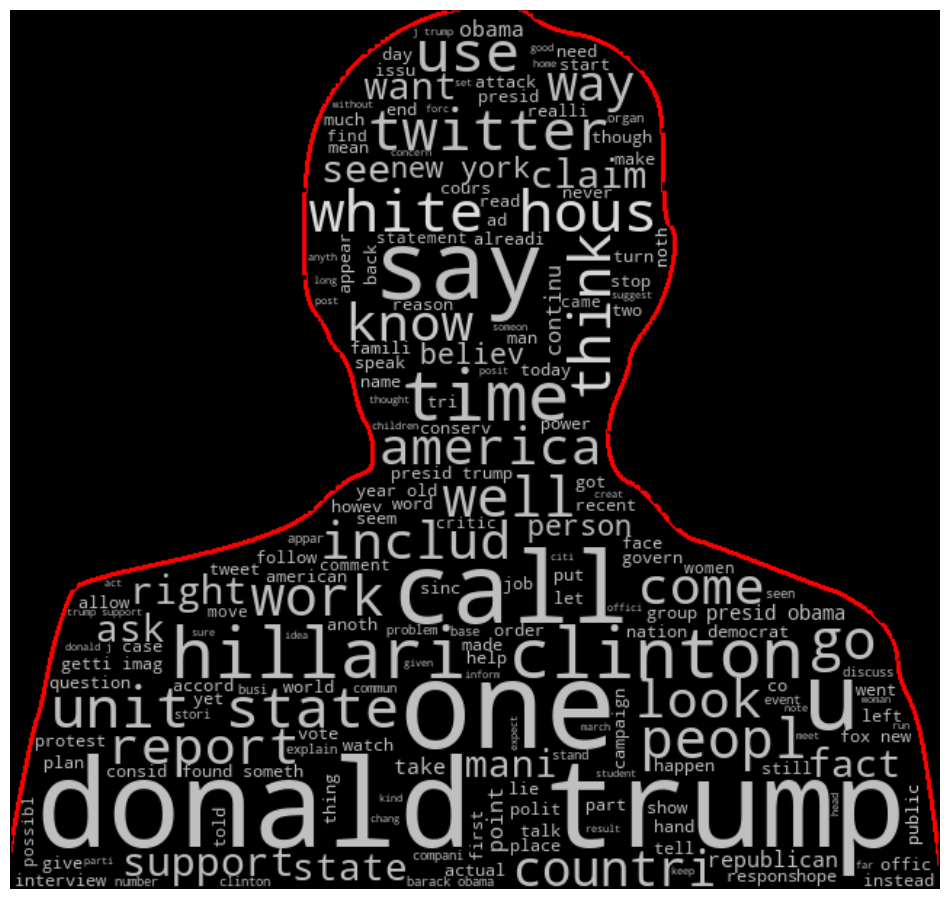

In [58]:
# fake_news

# Concatenate all the 'stem_text' into a single string
string_Total1 = " ".join(fake["stem_text"])

# Load the image mask (make sure to provide the correct path to the image)
mask_path = r"C:\Users\Amol\2.PROJECT\Real and fake news\last\R.png"
mask = np.array(Image.open(mask_path))

# Create a WordCloud object and set the image mask
wordcloud = WordCloud(background_color='black', mask=mask, contour_width=1, contour_color='red')
# Generate the word cloud
wordcloud.generate(string_Total1)
# Create a color map from the image to apply to the word cloud
image_colors = ImageColorGenerator(mask)

# Display the word cloud with the mask shape
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud.recolor(color_func=image_colors,random_state=42), interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

### Observations:

* The word cloud for fake news reveals mentions of prominent figures like Donald Trump, Hillary Clinton, and Barack Obama. Political party names like the Republican Party and terms like "said" (indicating statements) are also prevalent. Additionally, the word "Twitter" indicates a common source for spreading fake news.

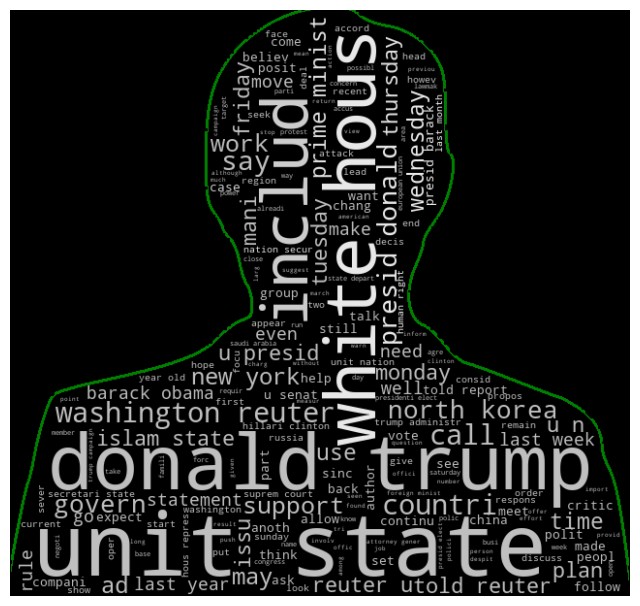

In [59]:
# Real_news

# Concatenate all the 'stem_text' into a single string
string_Total1 = " ".join(real["stem_text"])

# Load the image mask (make sure to provide the correct path to the image)
mask_path =  r"C:\Users\Amol\2.PROJECT\Real and fake news\last\R.png"
mask = np.array(Image.open(mask_path))

# Create a WordCloud object and set the image mask
wordcloud = WordCloud(background_color='black', mask=mask, contour_width=1, contour_color='green')
# Generate the word cloud
wordcloud.generate(string_Total1)
# Create a color map from the image to apply to the word cloud
image_colors = ImageColorGenerator(mask)

# Display the word cloud with the mask shape
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud.recolor(color_func=image_colors,random_state=42), interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()


### Observations:
* The word cloud for real news depicts mentions of weekdays, months, and social issues like racism and the Islamic State. The news agency "Reuters," White House, and Donald Trump are also commonly referenced in true news articles.
* If we observe there are some words in the real which are not in fake like there are many fake news about Cliton.

### N-gram
             N-gram analysis reveals common combinations of words in both fake and real news articles, giving a glimpse into their respective themes and topics. 
             These insights can be used to better understand the nature of fake news and its distinguishing characteristics compared to genuine news.

In [60]:
# Uni-gram for both dataset

# Create a TfidfVectorizer instance
tfidf_vectorizer_fk = TfidfVectorizer()
tfidf_vectorizer_rl = TfidfVectorizer()
# Fit and transform the processed_text column
tfidf_matrix_fk = tfidf_vectorizer_fk.fit_transform(fake['stem_text'])
tfidf_matrix_rl = tfidf_vectorizer_rl.fit_transform(real['stem_text'])
# Get the feature names (unigram tokens)
feature_names_fk = tfidf_vectorizer_fk.get_feature_names_out()
feature_names_rl = tfidf_vectorizer_rl.get_feature_names_out()
# Calculate the sum of TF-IDF values for each unigram across all documents
unigram_counts_fk = tfidf_matrix_fk.sum(axis=0)
unigram_counts_rl = tfidf_matrix_rl.sum(axis=0)
# Create a DataFrame with unigram words and their counts
unigram_count_fk = pd.DataFrame(unigram_counts_fk.T, index=feature_names_fk, columns=['TF-IDF Fake Count'])
unigram_count_rl = pd.DataFrame(unigram_counts_rl.T, index=feature_names_rl, columns=['TF-IDF Real Count'])
# Sort the DataFrame by count in descending order
unigram_count_fk = unigram_count_fk.sort_values(by='TF-IDF Fake Count', ascending=False)
unigram_count_rl = unigram_count_rl.sort_values(by='TF-IDF Real Count', ascending=False)
# Display the results
print(unigram_count_fk)
print('-----------------')
print(unigram_count_rl)

                          TF-IDF Fake Count
trump                           1412.267886
presid                           548.727691
clinton                          500.715399
obama                            460.441606
peopl                            448.993019
...                                     ...
sir_ex                             0.002664
goog_acknowledge_monitor           0.002664
max_length                         0.002664
naturalwidth                       0.002664
creative_load                      0.002664

[59966 rows x 1 columns]
-----------------
            TF-IDF Real Count
trump             1022.158287
state              606.945531
presid             533.982868
republican         509.441093
would              504.329275
...                       ...
caroni               0.014105
romelia              0.014105
lebrun               0.014105
enano                0.014105
letterhead           0.014105

[45937 rows x 1 columns]


- The higher the TF-IDF count, the more important and less common the word is across the documents.

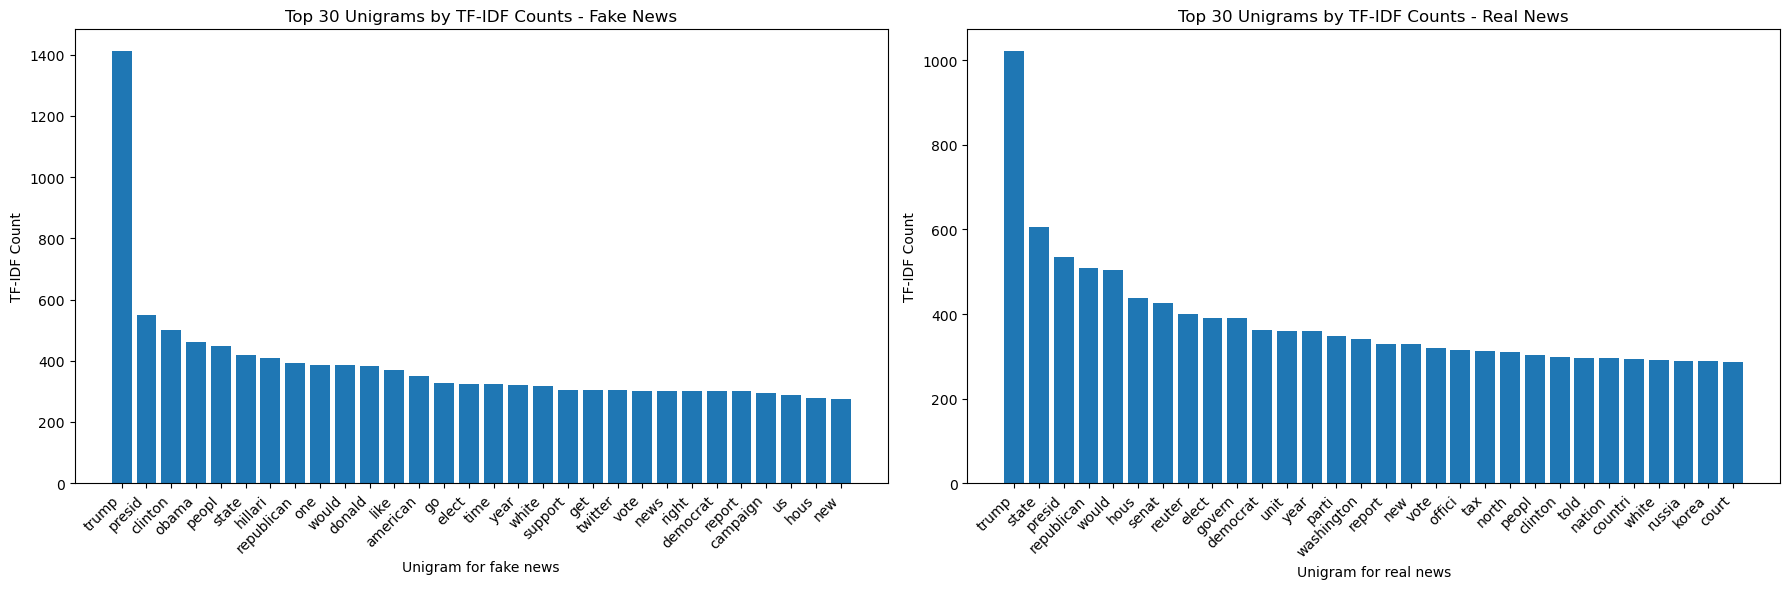

In [61]:
# Select the top 30 words for fake news
top_30_unigrams_fk = unigram_count_fk.head(30)
# Select the top 30 words for real news
top_30_unigrams_rl = unigram_count_rl.head(30)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot top 30 unigrams for fake news
ax1.bar(top_30_unigrams_fk.index, top_30_unigrams_fk['TF-IDF Fake Count'])
ax1.set_xticklabels(top_30_unigrams_fk.index, rotation=45, ha='right')
ax1.set_xlabel('Unigram for fake news')
ax1.set_ylabel('TF-IDF Count')
ax1.set_title('Top 30 Unigrams by TF-IDF Counts - Fake News')

# Plot top 30 unigrams for real news
ax2.bar(top_30_unigrams_rl.index, top_30_unigrams_rl['TF-IDF Real Count'])
ax2.set_xticklabels(top_30_unigrams_rl.index, rotation=45, ha='right')
ax2.set_xlabel('Unigram for real news')
ax2.set_ylabel('TF-IDF Count')
ax2.set_title('Top 30 Unigrams by TF-IDF Counts - Real News')

plt.tight_layout()
plt.show()


In [62]:
# Top 50 Unique words that differentiate real and fake news for unigram

# Calculate the absolute difference in TF-IDF scores between fake and real news
unigram_count_fk['TF-IDF Real Count'] = unigram_count_rl['TF-IDF Real Count']
unigram_count_fk['TF-IDF Difference'] = abs(unigram_count_fk['TF-IDF Fake Count'] - unigram_count_fk['TF-IDF Real Count'])

# Sort the DataFrame by the TF-IDF difference in descending order to get the most distinguishing words
unigram_count_fk = unigram_count_fk.sort_values(by='TF-IDF Difference', ascending=False)

# Select the top 50 words that differentiate fake news
top_fake_words = unigram_count_fk[unigram_count_fk['TF-IDF Fake Count'] > unigram_count_fk['TF-IDF Real Count']].head(50).index.tolist()

# Select the top 50 words that differentiate real news
top_real_words = unigram_count_fk[unigram_count_fk['TF-IDF Real Count'] > unigram_count_fk['TF-IDF Fake Count']].head(50).index.tolist()

# Print the lists of top 50 unique words that differentiate fake and real news
print("Top 50 unique words differentiating fake news:")
print(top_fake_words)

print("\nTop 50 unique words differentiating real news:")
print(top_real_words)


Top 50 unique words differentiating fake news:
['trump', 'one', 'hillari', 'twitter', 'us', 'watch', 'clinton', 'black', 'like', 'know', 'obama', 'america', 'http', 'get', 'american', 'thing', 'go', 'peopl', 'gop', 'fact', 'gun', 'fox', 'women', 'actual', 'realli', 'lie', 'getti', 'live', 'hate', 'racist', 'think', 'media', 'man', 'donald', 'read', 'cnn', 'time', 'mr', 'stori', 'everi', 'woman', 'imag', 'tell', 'student', 'got', 'seem', 'claim', 'guy', 'youtub', 'news']

Top 50 unique words differentiating real news:
['reuter', 'minist', 'korea', 'china', 'north', 'senat', 'may', 'washington', 'state', 'eu', 'govern', 'tax', 'wednesday', 'thursday', 'region', 'unit', 'trade', 'hous', 'tuesday', 'friday', 'offici', 'european', 'sanction', 'moscow', 'monday', 'iran', 'nuclear', 'spokesman', 'britain', 'foreign', 'rule', 'prime', 'leader', 'ministri', 'committe', 'missil', 'meet', 'militari', 'myanmar', 'court', 'would', 'legisl', 'republican', 'turkey', 'parti', 'parliament', 'statement'

##### Observations: 
* Top unique words in Unigrams for Fake News:

      "Trump," "hillari, "twitter", "black," "clinton," etc.

* Top unique words in Unigrams for Real News:

      "reuter," "minister," "korea," "china," "washington," etc.

In [63]:
# Bi-gram for both dataset

# Create a TfidfVectorizer instance
tfidf_vectorizer_fk = TfidfVectorizer(ngram_range=(2, 2))
tfidf_vectorizer_rl = TfidfVectorizer(ngram_range=(2, 2))
# Fit and transform the processed_text column
tfidf_matrix_fk = tfidf_vectorizer_fk.fit_transform(fake['stem_text'])
tfidf_matrix_rl = tfidf_vectorizer_rl.fit_transform(real['stem_text'])
# Get the feature names (bigram tokens)
feature_names_fk = tfidf_vectorizer_fk.get_feature_names_out()
feature_names_rl = tfidf_vectorizer_rl.get_feature_names_out()
# Calculate the sum of TF-IDF values for each bigram across all documents
bigram_counts_fk = tfidf_matrix_fk.sum(axis=0)
bigram_counts_rl = tfidf_matrix_rl.sum(axis=0)
# Create a DataFrame with bigram words and their counts
bigram_count_fk = pd.DataFrame(bigram_counts_fk.T, index=feature_names_fk, columns=['TF-IDF Fake Count'])
bigram_count_rl = pd.DataFrame(bigram_counts_rl.T, index=feature_names_rl, columns=['TF-IDF Real Count'])
# Sort the DataFrame by count in descending order
bigram_count_fk = bigram_count_fk.sort_values(by='TF-IDF Fake Count', ascending=False)
bigram_count_rl = bigram_count_rl.sort_values(by='TF-IDF Real Count', ascending=False)
# Display the results
print(bigram_count_fk)
print('-----------------')
print(bigram_count_rl)

                 TF-IDF Fake Count
donald trump            233.654425
hillari clinton         140.473153
white hous              131.841082
unit state              113.775246
presid trump             98.348353
...                            ...
indexof amp               0.003944
puppet manipul            0.003944
ticket make               0.003944
ref quot                  0.003944
amp join                  0.003944

[1787810 rows x 1 columns]
-----------------
                   TF-IDF Real Count
unit state                201.420048
white hous                176.541740
donald trump              166.825085
north korea               157.662595
washington reuter         153.995237
...                              ...
florida announc             0.016181
counti aug                  0.016181
total sourc                 0.016181
zika palm                   0.016181
florida investig            0.016181

[1664053 rows x 1 columns]


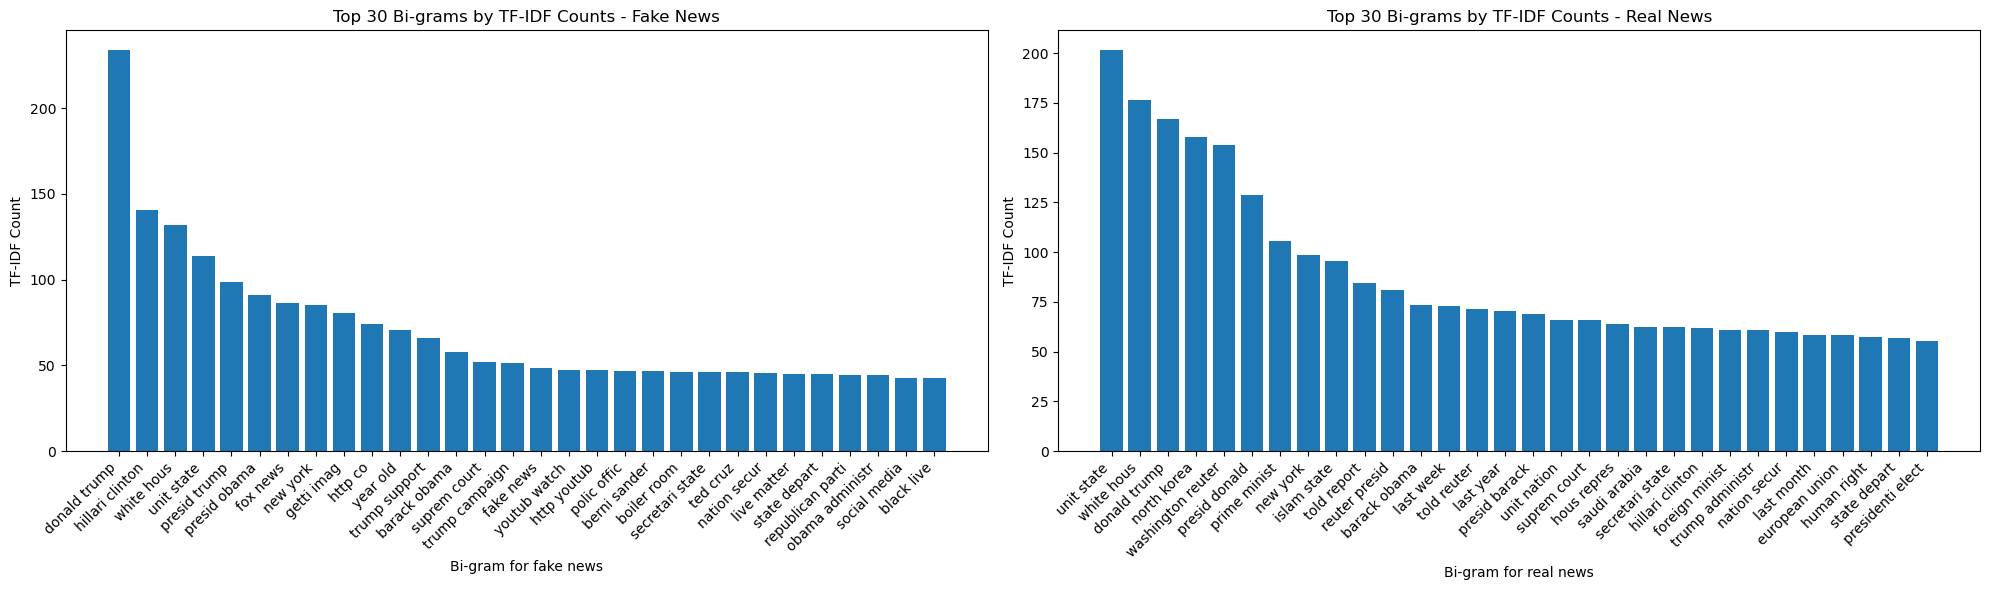

In [64]:
# Select the top 30 words for fake news
top_30_bigrams_fk = bigram_count_fk.head(30)
# Select the top 30 words for real news
top_30_bigrams_rl = bigram_count_rl.head(30)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot top 30 Bi-grams for fake news
ax1.bar(top_30_bigrams_fk.index, top_30_bigrams_fk['TF-IDF Fake Count'])
ax1.set_xticklabels(top_30_bigrams_fk.index, rotation=45, ha='right')
ax1.set_xlabel('Bi-gram for fake news')
ax1.set_ylabel('TF-IDF Count')
ax1.set_title('Top 30 Bi-grams by TF-IDF Counts - Fake News')

# Plot top 30 Bi-grams for real news
ax2.bar(top_30_bigrams_rl.index, top_30_bigrams_rl['TF-IDF Real Count'])
ax2.set_xticklabels(top_30_bigrams_rl.index, rotation=45, ha='right')
ax2.set_xlabel('Bi-gram for real news')
ax2.set_ylabel('TF-IDF Count')
ax2.set_title('Top 30 Bi-grams by TF-IDF Counts - Real News')

plt.tight_layout()
plt.show()

In [65]:
# Top 50 Unique words that differentiate real and fake news for bigram

# Calculate the absolute difference in TF-IDF scores between fake and real news
bigram_count_fk['TF-IDF Real Count'] = bigram_count_rl['TF-IDF Real Count']
bigram_count_fk['TF-IDF Difference'] = abs(bigram_count_fk['TF-IDF Fake Count'] - bigram_count_fk['TF-IDF Real Count'])

# Sort the DataFrame by the TF-IDF difference in descending order to get the most distinguishing words
bigram_count_fk = bigram_count_fk.sort_values(by='TF-IDF Difference', ascending=False)

# Select the top 50 words that differentiate fake news
top_fake_words = bigram_count_fk[bigram_count_fk['TF-IDF Fake Count'] > bigram_count_fk['TF-IDF Real Count']].head(50).index.tolist()

# Select the top 50 words that differentiate real news
top_real_words = bigram_count_fk[bigram_count_fk['TF-IDF Real Count'] > bigram_count_fk['TF-IDF Fake Count']].head(50).index.tolist()

# Print the lists of top 50 unique words that differentiate fake and real news
print("Top 50 unique words differentiating fake news:")
print(top_fake_words)

print("\nTop 50 unique words differentiating real news:")
print(top_real_words)


Top 50 unique words differentiating fake news:
['presid obama', 'hillari clinton', 'presid trump', 'donald trump', 'fox news', 'trump support', 'live matter', 'black live', 'fake news', 'look like', 'polic offic', 'mainstream media', 'illeg alien', 'berni sander', 'gon na', 'bill clinton', 'centuri say', 'ted cruz', 'american peopl', 'breitbart news', 'african american', 'clinton foundat', 'becom member', 'white supremacist', 'first ladi', 'mr trump', 'right wing', 'last night', 'washington post', 'presid unit', 'daili mail', 'sexual assault', 'black peopl', 'anti trump', 'republican parti', 'white peopl', 'press confer', 'daili caller', 'sean hanniti', 'law enforc', 'health care', 'plan parenthood', 'pretti much', 'trump ralli', 'nation anthem', 'york time', 'high school', 'free speech', 'year old', 'secret servic']

Top 50 unique words differentiating real news:
['washington reuter', 'north korea', 'presid donald', 'unit state', 'prime minist', 'reuter presid', 'islam state', 'told r

### Observations: 
* Top unique words in Bigrams for Fake News:

      'presid obama', 'hillari clinton','presid trump', 'fox news', 'trump support',  'live matter' etc

* Top unique words in Bigrams for Real News:

      'washington reuter', 'north korea', 'presid donald', 'unit state', 'prime minist' etc

In [66]:
# Tri-gram for both dataset

# Create a TfidfVectorizer instance
tfidf_vectorizer_fk = TfidfVectorizer(ngram_range=(3, 3))
tfidf_vectorizer_rl = TfidfVectorizer(ngram_range=(3, 3))
# Fit and transform the processed_text column
tfidf_matrix_fk = tfidf_vectorizer_fk.fit_transform(fake['stem_text'])
tfidf_matrix_rl = tfidf_vectorizer_rl.fit_transform(real['stem_text'])
# Get the feature names (trigram tokens)
feature_names_fk = tfidf_vectorizer_fk.get_feature_names_out()
feature_names_rl = tfidf_vectorizer_rl.get_feature_names_out()
# Calculate the sum of TF-IDF values for each trigram across all documents
trigram_counts_fk = tfidf_matrix_fk.sum(axis=0)
trigram_counts_rl = tfidf_matrix_rl.sum(axis=0)
# Create a DataFrame with trigram words and their counts
trigram_count_fk = pd.DataFrame(trigram_counts_fk.T, index=feature_names_fk, columns=['TF-IDF Fake Count'])
trigram_count_rl = pd.DataFrame(trigram_counts_rl.T, index=feature_names_rl, columns=['TF-IDF Real Count'])
# Sort the DataFrame by count in descending order
trigram_count_fk = trigram_count_fk.sort_values(by='TF-IDF Fake Count', ascending=False)
trigram_count_rl = trigram_count_rl.sort_values(by='TF-IDF Real Count', ascending=False)
# Display the results
print(trigram_count_fk)
print('-----------------')
print(trigram_count_rl)

                          TF-IDF Fake Count
http youtub watch                 47.639444
black live matter                 38.710320
new york time                     35.385365
presid donald trump               30.863425
presid unit state                 29.086239
...                                     ...
distribut cocain two               0.005351
distribut cocain use               0.005351
distribut cocain western           0.005351
distribut crack possess            0.005351
distribut cocain interst           0.005351

[3384290 rows x 1 columns]
-----------------
                          TF-IDF Real Count
presid donald trump              113.592949
presid barack obama               61.474432
washington reuter presid          55.513152
reuter presid donald              53.559641
elect donald trump                31.316673
...                                     ...
report three addit                 0.019395
zika case florida                  0.019395
total sourc world             

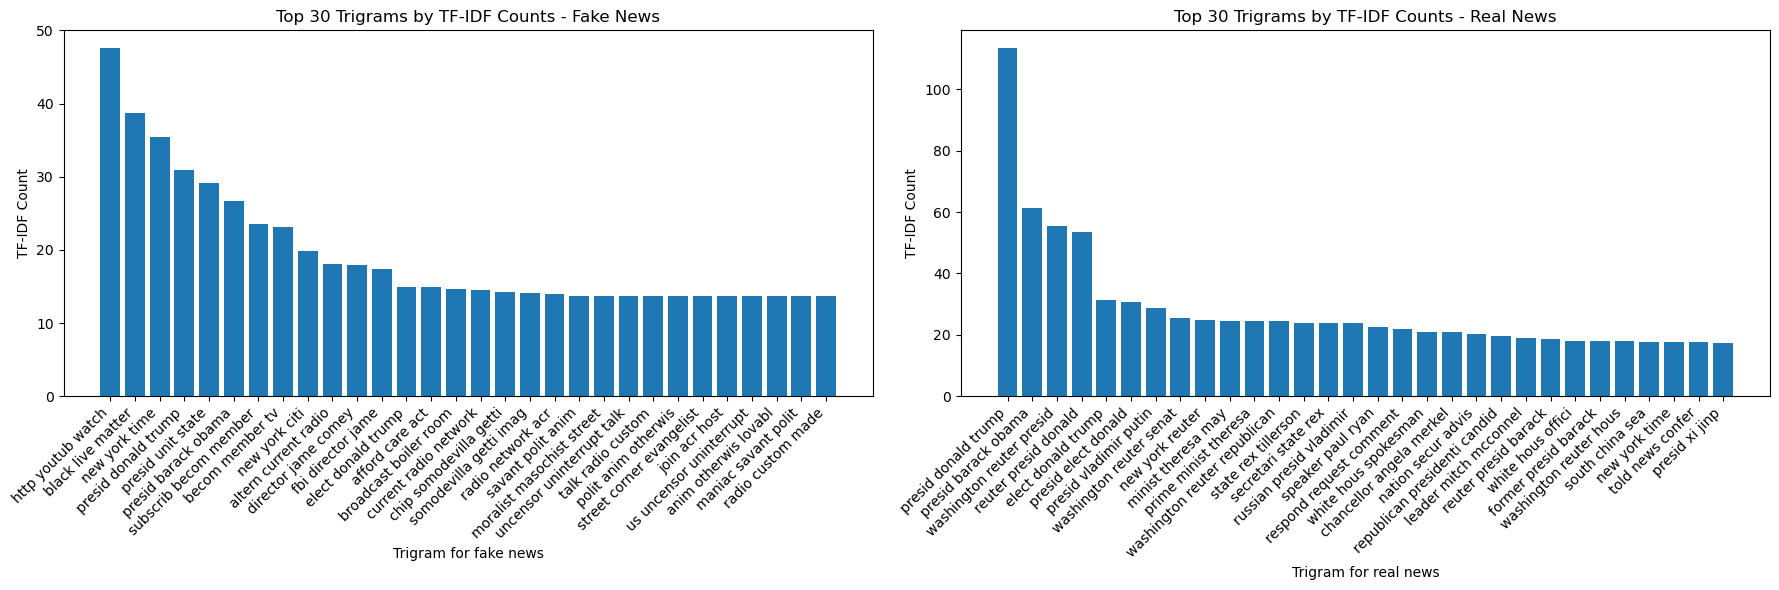

In [67]:
# Select the top 30 words for fake news
top_30_trigrams_fk = trigram_count_fk.head(30)
# Select the top 30 words for real news
top_30_trigrams_rl = trigram_count_rl.head(30)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot top 30 trigrams for fake news
ax1.bar(top_30_trigrams_fk.index, top_30_trigrams_fk['TF-IDF Fake Count'])
ax1.set_xticklabels(top_30_trigrams_fk.index, rotation=45, ha='right')
ax1.set_xlabel('Trigram for fake news')
ax1.set_ylabel('TF-IDF Count')
ax1.set_title('Top 30 Trigrams by TF-IDF Counts - Fake News')

# Plot top 30 trigrams for real news
ax2.bar(top_30_trigrams_rl.index, top_30_trigrams_rl['TF-IDF Real Count'])
ax2.set_xticklabels(top_30_trigrams_rl.index, rotation=45, ha='right')
ax2.set_xlabel('Trigram for real news')
ax2.set_ylabel('TF-IDF Count')
ax2.set_title('Top 30 Trigrams by TF-IDF Counts - Real News')

plt.tight_layout()
plt.show()

In [68]:
# Top 50 Unique words that differentiate real and fake news for trigram

# Calculate the absolute difference in TF-IDF scores between fake and real news
trigram_count_fk['TF-IDF Real Count'] = trigram_count_rl['TF-IDF Real Count']
trigram_count_fk['TF-IDF Difference'] = abs(trigram_count_fk['TF-IDF Fake Count'] - trigram_count_fk['TF-IDF Real Count'])

# Sort the DataFrame by the TF-IDF difference in descending order to get the most distinguishing words
trigram_count_fk = trigram_count_fk.sort_values(by='TF-IDF Difference', ascending=False)

# Select the top 50 words that differentiate fake news
top_fake_words = trigram_count_fk[trigram_count_fk['TF-IDF Fake Count'] > trigram_count_fk['TF-IDF Real Count']].head(50).index.tolist()

# Select the top 50 words that differentiate real news
top_real_words = trigram_count_fk[trigram_count_fk['TF-IDF Real Count'] > trigram_count_fk['TF-IDF Fake Count']].head(50).index.tolist()

# Print the lists of top 50 unique words that differentiate fake and real news
print("Top 50 unique words differentiating fake news:")
print(top_fake_words)

print("\nTop 50 unique words differentiating real news:")
print(top_real_words)

Top 50 unique words differentiating fake news:
['black live matter', 'presid unit state', 'new york time', 'paul joseph watson', 'fox news host', 'support donald trump', 'white hous press', 'unit state america', 'saturday night live', 'donald trump januari', 'like donald trump', 'new york citi', 'suprem court justic', 'live matter movement', 'donald trump septemb', 'donald trump jr', 'donald trump presid', 'donald trump june', 'law enforc offic', 'vote donald trump', 'vote hillari clinton', 'hillari clinton campaign', 'year old girl', 'hous press secretari', 'donald trump octob', 'martin luther king', 'anti trump protest', 'press secretari sean', 'secretari sean spicer', 'donald trump februari', 'former realiti star', 'donald trump august', 'secret servic agent', 'donald trump novemb', 'donald trump march', 'dr ben carson', 'world war ii', 'sen john mccain', 'new york post', 'berni sander support', 'fbi director jame', 'donald trump support', 'nation secur advisor', 'first ladi melania

### Observations: 
* Top unique words in Trigrams for Fake News:

      'black live matter', 'presid unit state', 'new york time', 'paul joseph watson', 'fox news host', 'support donald trump', 'white hous press' etc

* Top unique words in Trigrams for Real News:

      'presid donald trump', 'reuter presid donald', 'presid barack obama', 'washington reuter senat',  'presid vladimir putin', 'presid elect donald', 'secretari state rex' etc

* From Uni ,Bi and trigram we can clearly observed that trigram gives more meaningful information about text.

### Sentiment analysis 

In [69]:
def sentiment_analysis(row):
    sentiment = TextBlob(row["stem_text"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

In [70]:
fake[["subjectivity", "polarity"]] = fake.apply(lambda row: sentiment_analysis(row), axis=1)
real[["subjectivity", "polarity"]] = real.apply(lambda row: sentiment_analysis(row), axis=1)

# Compute The Negative, Neutral, Positive Analysis
def analysis(score):
    if score >= 0.05:
        return "Positive"
    elif score == -0.05:
        return "Negative"
    else:
        return "Neutral"
    
# Creating a New sentiment Column
fake["sentiments"] = fake["polarity"].apply(analysis)
real["sentiments"] = real["polarity"].apply(analysis)

In [71]:
fake.head()

,title,text,subject,date,Class,title_length,links_count,clean_text,tokenized_text,stem_text,subjectivity,polarity,sentiments
0,Donald Trump Sends Out Embarrassing New Year...,donald trump just couldn t wish all americans ...,News,2017-12-31,Fake,79,0,donald trump just couldn wish all americans ha...,"[donald, trump, wish, americans, happy, new, y...",donald trump wish american happi new year leav...,0.514865,0.012613,Neutral
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,2017-12-31,Fake,69,0,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",hous intellig committe chairman devin nune go ...,0.272007,0.046341,Neutral
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,2017-12-30,Fake,90,1,on friday it was revealed that former milwauk...,"[friday, revealed, former, milwaukee, sheriff,...",friday reveal former milwauke sheriff david cl...,0.486140,-0.054137,Neutral
3,Trump Is So Obsessed He Even Has Obamas Name...,"on christmas day, donald trump announced that ...",News,2017-12-29,Fake,78,4,on christmas day donald trump announced that ...,"[christmas, day, donald, trump, announced, wou...",christma day donald trump announc would back w...,0.341477,-0.008523,Neutral
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,2017-12-25,Fake,70,0,pope francis used his annual christmas day mes...,"[pope, francis, used, annual, christmas, day, ...",pope franci use annual christma day messag reb...,0.536111,-0.034259,Neutral


In [72]:
real.head()

,title,text,subject,date,Class,title_length,links_count,clean_text,tokenized_text,stem_text,subjectivity,polarity,sentiments
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,2017-12-31,True,64,0,washington reuters the head of conservativ...,"[washington, reuters, head, conservative, repu...",washington reuter head conserv republican fact...,0.419712,0.035737,Neutral
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,2017-12-29,True,64,0,washington reuters transgender people will...,"[washington, reuters, transgender, people, all...",washington reuter transgend peopl allow first ...,0.408690,0.125190,Positive
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington (reuters) - the special counsel inv...,politicsNews,2017-12-31,True,60,0,washington reuters the special counsel inv...,"[washington, reuters, special, counsel, invest...",washington reuter special counsel investig lin...,0.389320,0.242429,Positive
3,FBI Russia probe helped by Australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsNews,2017-12-30,True,59,0,washington reuters trump campaign adviser ...,"[washington, reuters, trump, campaign, adviser...",washington reuter trump campaign advis georg p...,0.318489,0.091480,Positive
4,Trump wants Postal Service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsNews,2017-12-29,True,69,0,seattle washington reuters president donal...,"[seattle, washington, reuters, president, dona...",seattl washington reuter presid donald trump c...,0.378788,-0.007323,Neutral


In [73]:
# count of +ve,-ve & neutral sentiments of fake news
print(fake['sentiments'].value_counts())
# count of +ve,-ve & neutral sentiments of real news
real['sentiments'].value_counts()

Positive    12541
Neutral     10265
Negative       36
Name: sentiments, dtype: int64


Positive    11112
Neutral     10063
Negative       34
Name: sentiments, dtype: int64

## Exploratory Data Analysis (EDA) and Visualization Report

#### 1. Missing Dates in Fake News Dataset:
- There are 35 rows in the fake news dataset with the date labeled as "Nat," indicating invalid or missing date entries.
- All dates with null values are from fake news with a political background.

#### 2. Blank Descriptions:
- 626 fake news articles have blank descriptions, while only one such article exists in the real news dataset.

#### 3. Subjects in Fake News:
- Fake news has five subjects, with the 'news' subject having the highest rate of publishing fake news.
- The possibility of publishing fake news from US news & the Middle East subjects is very low.

#### 4. Subjects Comparison between Fake and Real News:
- News related to the 'worldnews' subject was more prevalent in the real news dataset.

#### 5. News Articles on Politics:
- Real news articles on the 'politics' topic outnumber fake news articles.

#### 6. Fake News Counts Over Time:
- The average number of fake news articles is around 600 per month.

#### 7. Real News Counts Over Time:
- Real news rates were highest in October, November, and December, with an average of around 600 articles per month.

#### 8. Fake News Release Dates:
- The analysis indicates that real news is more likely to be released at the end of the year.

#### 9. Fake News Counts in Middle of the Year:
- The middle of the year (January, April, May, June, July, August) saw the maximum rate of publishing fake news.

#### 10. Comparison of Fake and Real News Articles by Year:**
- The year 2016 saw a higher percentage of fake news articles compared to true news articles.
- In contrast, the year 2017 had more true news articles.

#### 11. Title Length in Fake and Real News:
- Real news titles tend to have shorter lengths, primarily up to 100 characters, while fake news titles can be longer, reaching up to 200 characters.

#### 12. Word "Reuters" in News Articles:
- The word "Reuters" is commonly found in the real news dataset, indicating a reputable US news agency.
- In contrast, it appears rarely in the fake news dataset.

#### 13. Presence of URLs:
- The percentage of URLs present in the fake dataset is 20%, while it is zero in real news.
- This feature could be important for identifying real and fake news.

#### 14. Word Clouds:
- The word cloud for fake news reveals prominent figures like Donald Trump, Hillary Clinton, and Barack Obama. Political party names and terms like "said" are also prevalent.
- The word cloud for real news depicts mentions of weekdays, months, and social issues like racism and the Islamic State. The news agency "Reuters," White House, and Donald Trump are commonly referenced.

#### 15. Unique Words Analysis:
- Unigrams, bigrams, and trigrams provide insights into the unique words used in fake and real news.
- Trigrams appear to provide the most meaningful information about the text.

### Conclusion:
- The analysis provides valuable insights into the differences between real and fake news articles.
- Features such as subject, title length, presence of URLs, and certain keywords like "Reuters" and prominent figures can be considered important for model building and identifying real and fake news.
- Further analysis may be required to understand the patterns in the fake news release dates and the reasons behind the missing dates in fake news articles.

## Step 5 Feature Engineering

#### Based on the insights and findings from the EDA and plots we are going to derive some important features so that it becomes an important feature for model building 

### Concanating both fake and real dataset.

In [74]:
combine_news = pd.concat([fake, real], axis=0,ignore_index=True)
combine_news.tail(2)

,title,text,subject,date,Class,title_length,links_count,clean_text,tokenized_text,stem_text,subjectivity,polarity,sentiments
44049,Vatican upbeat on possibility of Pope Francis ...,moscow (reuters) - vatican secretary of state ...,worldnews,2017-08-22,True,61,0,moscow reuters vatican secretary of state ...,"[moscow, reuters, vatican, secretary, state, c...",moscow reuter vatican secretari state cardin p...,0.231933,-0.021849,Neutral
44050,Indonesia to buy $1.14 billion worth of Russia...,jakarta (reuters) - indonesia will buy 11 sukh...,worldnews,2017-08-22,True,52,0,jakarta reuters indonesia will buy sukhoi...,"[jakarta, reuters, indonesia, buy, sukhoi, fig...",jakarta reuter indonesia buy sukhoi fighter je...,0.208747,0.040427,Neutral


In [75]:
# creating new column with reuters word
combine_news['Reuters_present'] = combine_news['text'].str.contains(r'\(reuters\)')
combine_news['Reuters_present'].value_counts()

False    23002
True     21049
Name: Reuters_present, dtype: int64

In [76]:
combine_news['text_blank']=np.where(combine_news['text']==' ',True, False)

In [77]:
pd.crosstab(combine_news['Class'],combine_news['Reuters_present'])

Reuters_present,False,True
Class,,
Fake,22833,9
True,169,21040


In [78]:
combine_news.columns

Index(['title', 'text', 'subject', 'date', 'Class', 'title_length',
       'links_count', 'clean_text', 'tokenized_text', 'stem_text',
       'subjectivity', 'polarity', 'sentiments', 'Reuters_present',
       'text_blank'],
      dtype='object')

In [79]:
# Accessing only important columns for model building
df=combine_news[['title_length','links_count','Reuters_present','stem_text','Class','text_blank']]
print(df.shape)
df.head()

(44051, 6)


,title_length,links_count,Reuters_present,stem_text,Class,text_blank
0,79,0,False,donald trump wish american happi new year leav...,Fake,False
1,69,0,False,hous intellig committe chairman devin nune go ...,Fake,False
2,90,1,False,friday reveal former milwauke sheriff david cl...,Fake,False
3,78,4,False,christma day donald trump announc would back w...,Fake,False
4,70,0,False,pope franci use annual christma day messag reb...,Fake,False


In [80]:
# Encoding categorical columns into numerical
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['Reuters_present']=encoder.fit_transform(df['Reuters_present'])
df['text_blank']=encoder.fit_transform(df['text_blank'])
df['Class']=encoder.fit_transform(df['Class'])
df.head(20)

,title_length,links_count,Reuters_present,stem_text,Class,text_blank
0,79,0,0,donald trump wish american happi new year leav...,0,0
1,69,0,0,hous intellig committe chairman devin nune go ...,0,0
2,90,1,0,friday reveal former milwauke sheriff david cl...,0,0
3,78,4,0,christma day donald trump announc would back w...,0,0
4,70,0,0,pope franci use annual christma day messag reb...,0,0
5,82,0,0,number case cop brutal kill peopl color seem s...,0,0
6,83,0,0,donald trump spent good portion day golf club ...,0,0
7,87,0,0,wake yet anoth court decis derail donald trump...,0,0
8,102,0,0,mani peopl rais alarm regard fact donald trump...,0,0
9,81,0,0,might thought get break watch peopl kiss donal...,0,0


In [81]:
# applying minmax scaler 
from sklearn.preprocessing import MinMaxScaler 
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(df[['title_length','links_count','Reuters_present','text_blank']])
df1

array([[0.23616236, 0.        , 0.        , 0.        ],
       [0.19926199, 0.        , 0.        , 0.        ],
       [0.27675277, 0.04545455, 0.        , 0.        ],
       ...,
       [0.12546125, 0.        , 1.        , 0.        ],
       [0.1697417 , 0.        , 1.        , 0.        ],
       [0.13653137, 0.        , 1.        , 0.        ]])

In [82]:
# Convert the array to a DataFrame
df1 = pd.DataFrame(df1, columns=['title_length','links_count','Reuters_present','text_blank'])
df1.head()

,title_length,links_count,Reuters_present,text_blank
0,0.236162,0.000000,0.0,0.0
1,0.199262,0.000000,0.0,0.0
2,0.276753,0.045455,0.0,0.0
3,0.232472,0.181818,0.0,0.0
4,0.202952,0.000000,0.0,0.0


In [83]:
df= pd.concat([df1,df['stem_text'],df['Class']], axis=1)
df.head()

,title_length,links_count,Reuters_present,text_blank,stem_text,Class
0,0.236162,0.000000,0.0,0.0,donald trump wish american happi new year leav...,0
1,0.199262,0.000000,0.0,0.0,hous intellig committe chairman devin nune go ...,0
2,0.276753,0.045455,0.0,0.0,friday reveal former milwauke sheriff david cl...,0
3,0.232472,0.181818,0.0,0.0,christma day donald trump announc would back w...,0
4,0.202952,0.000000,0.0,0.0,pope franci use annual christma day messag reb...,0


### Word Embedding/Vectorization
-Word embeddings is a technique where individual words are transformed into a numerical representation of the word (a vector). Where each word is mapped to one vector.there are 2 type of WE,


  1.Frequncy Based Embedding
  
       i) CV
      ii) TF-IDF
  2.Prediction based embedding
  
       i) Word2Vec

#### Using tf-idf 

In [84]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['stem_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,abl,abort,absolut,abus,accept,access,accord,account,accus,across,...,worri,would,write,wrong,wrote,ye,year,yet,york,young
0,0.0,0.0,0.0,0.0,0.046750,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.041950,0.0,0.049181,0.0,0.0,0.412363,0.000000,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.127308,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.15872,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.022481,0.000000,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.078061,0.0,0.000000,0.0,0.0,0.028419,0.000000,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.080724,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.069512,0.00000,0.083618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44046,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.074079,0.0,0.000000,0.0,0.0,0.053939,0.000000,0.00000,0.000000
44047,0.0,0.0,0.0,0.0,0.000000,0.132142,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.124342,0.000000,0.00000,0.000000
44048,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.170122,0.000000,0.00000,0.000000
44049,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.052404,0.000000,0.00000,0.000000


In [85]:
import pickle
# save the trained TF_IDF vectorizer to a file
with open('tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf_vectorizer,f)

In [86]:
df_pro = pd.concat([df, tfidf_df], axis=1)
df_pro.drop(columns=['stem_text','Class'],axis=1, inplace=True)
df_pro.head()

,title_length,links_count,Reuters_present,text_blank,abl,abort,absolut,abus,accept,access,...,worri,would,write,wrong,wrote,ye,year,yet,york,young
0,0.236162,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.046750,0.0,...,0.0,0.041950,0.0,0.049181,0.0,0.0,0.412363,0.000000,0.00000,0.000000
1,0.199262,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.15872,0.000000
2,0.276753,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.022481,0.000000,0.00000,0.000000
3,0.232472,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.078061,0.0,0.000000,0.0,0.0,0.028419,0.000000,0.00000,0.000000
4,0.202952,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.080724,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.069512,0.00000,0.083618


In [87]:
import pickle
# save the trained TF_IDF vectorizer to a file
with open('df_pro.pkl','wb') as f:
    pickle.dump(df_pro,f)

In [88]:
# separating feature and target column
X= df_pro
y=df['Class']

In [89]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## Feature Engineering Report

#### 1. Added Columns based on EDA:
a. **Length of Title (int):**
   - We calculated the length of each news article's title and added it as a new feature in the dataset. This feature represents the number of characters in the title.

b. **Link Count in the Text (int):**
   - We analyzed the text column to count the number of URLs or hyperlinks present in each news article. This count was added as a new feature in the dataset, representing the number of links in the article.

c. **Reuters Present or Absent (boolean):**
   - Based on the analysis of the news agency name "Reuters" in the EDA, we added a new boolean feature to indicate whether the news article mentions "Reuters" (True) or not (False).

d. **Text Blank (boolean):**
   - During the EDA, we identified articles with blank text descriptions. We added a new boolean feature to indicate whether the text field is blank (True) or contains some information (False).

#### 2. Performed TF-IDF and Word2Vec:
   - To process the text data and convert it into numerical vectors, we applied two popular techniques: TF-IDF and Word2Vec.
   - TF-IDF (Term Frequency-Inverse Document Frequency) was used to represent the importance of each word in the text with respect to the entire dataset.
   - Word2Vec was utilized to create word embeddings, i.e., dense vector representations of words, capturing their semantic relationships.

#### 3. Performed Min-Max Scaler:
   - After obtaining numerical features from TF-IDF and Word2Vec, we applied the Min-Max Scaler to scale all features to a specific range (usually [0, 1]).
   - Scaling helps in bringing all the features to a similar magnitude, preventing any particular feature from dominating the model due to its larger scale.

#### 4. Data Splitting:
   - We split the dataset into two parts: features (X) and target variable (y).
   - The features (X) consist of all the engineered features, including the length of the title, link count, Reuters presence, TF-IDF vectors, and Word2Vec embeddings.
   - The target variable (y) contains the labels indicating whether each news article is real (1) or fake (0).
   
#### 5. Train-Test Split:
   - To evaluate the performance of the machine learning model, we further split the dataset into training and testing sets.
   - The training set is used to train the model, while the testing set is used to assess its generalization and performance on unseen data.

### Conclusion:
   - Feature engineering is a crucial step in preparing the data for machine learning models.
   - We added several meaningful features based on the insights gained from the Exploratory Data Analysis (EDA).
   - By incorporating features like length of title, link count, Reuters presence, and text blankness, we aim to improve the model's ability to distinguish between real and fake news.
   - The use of TF-IDF and Word2Vec allows us to represent the text data numerically, capturing semantic relationships and word importance.
   - Scaling the features ensures that they are on a similar scale, preventing any feature from dominating the model based solely on its magnitude.
   - The dataset is now ready for building a machine learning model to classify news articles as real or fake based on the engineered features.

## Step 6 Model building for TF-IDF

### Logistic Regression

In [90]:
#Initialising Logistic Regression model
log_reg = LogisticRegression(random_state=42)
#Fitting the model on train data
log_reg.fit(X_train,y_train)
#Finding the accuracy score on test data
acc = log_reg.score(X_test,y_test)
print (acc)

0.9969356486210419


In [91]:
y_pred=log_reg.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 1, 1])

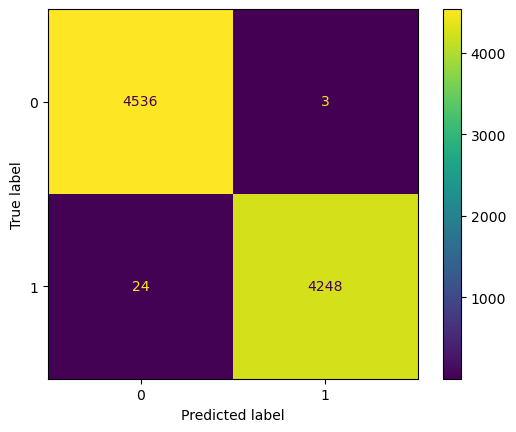

In [92]:
confu = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confu, display_labels = [0,1])
cm_display.plot()
plt.show()

In [93]:
# using kfold-cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(log_reg, X_train, y_train, cv=kfold, scoring='accuracy')
print("Cross-validated accuracy scores:", scores)

Cross-validated accuracy scores: [0.99787174 0.99772985 0.99659478 0.99772985 0.99744608]


In [94]:
print("Mean accuracy score:", np.mean(scores))

Mean accuracy score: 0.9974744608399545


In [95]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4539
           1       1.00      0.99      1.00      4272

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811



### Navie bayes

In [96]:
from sklearn.naive_bayes import MultinomialNB
# Initialsing a naive bayes classifier
nb = MultinomialNB()
# Fitting the model on train data
nb.fit(X_train, y_train)
# Finding the accuracy score of model on test data
nb_acc = nb.score(X_test, y_test)
print(nb_acc)

0.9846782431052093


### SVM

In [97]:
from sklearn.svm import SVC
#Initialising a support vector model with linear kernel
svc = SVC(kernel="linear", random_state=0)
#Fitting the model on train data
svc.fit(X_train,y_train)
#Finding the accuracy score of the model on test data
svc_score=svc.score(X_test,y_test)
print(svc_score)

0.9979570990806946


In [98]:
# Combining all Models accuracies and forming Dataframe
final_data_acc = pd.DataFrame({'Models':['LogisticReg','SVM','NaiveBayes'],
                          'Accuracy': [acc*100,svc_score*100,nb_acc*100]})
final_data_acc

,Models,Accuracy
0,LogisticReg,99.693565
1,SVM,99.795710
2,NaiveBayes,98.467824


## Using Word2Vec
          - In many NLP tasks, understanding the context and meaning of words is essential. Word embeddings help disambiguate words with multiple meanings based on their surrounding words. This is valuable in tasks like word sense disambiguation and coreference resolution.
          - Word2Vec allowing algorithms to understand language more contextually and semantically. They    have become an essential component in various NLP pipelines and have significantly improved the performance of many language-related tasks.

In [99]:
# Train the Word2Vec model with vector_size=1000
model = Word2Vec(sentences=combine_news['tokenized_text'], vector_size=1000, window=5)
# Save the trained model
model.save("word2vec_model_1000d.bin")
# Get the word vector for a specific word (e.g., 'machine')
word_vector = model.wv['trump']
print(f"Vector representation of 'trump': {word_vector}")

Vector representation of 'trump': [-1.51400730e-01  4.80646700e-01  2.27386907e-01  5.81742942e-01
 -6.26199245e-01 -9.27687824e-01  7.50548303e-01  2.20682085e-01
  1.38704017e-01 -1.01693678e+00 -1.56161547e-01 -3.49243730e-01
  1.53968722e-01  4.13465410e-01 -6.47511363e-01 -3.01406562e-01
 -1.33110628e-01  9.11198836e-03 -1.15190959e+00  2.64352739e-01
  8.88859868e-01  8.90768349e-01 -1.83408111e-01 -5.51222444e-01
  2.84687608e-01 -1.01532996e-01 -2.15050399e-01  9.09498572e-01
 -5.26074469e-01  2.76158661e-01  2.04994157e-01 -1.45156711e-01
  1.74144834e-01 -3.14090371e-01 -1.40454188e-01  4.79432017e-01
 -5.71604133e-01 -8.32730174e-01  8.23755339e-02 -2.13101450e-02
 -1.78504035e-01  1.15723860e+00  1.39055671e-02 -8.82434011e-01
  4.89091486e-01  6.40450954e-01  2.20692549e-02  7.52039015e-01
  9.10194397e-01  1.81986645e-01 -2.00294837e-01  3.44023034e-02
 -1.10935621e-01 -1.21043451e-01  1.31957993e-01 -8.15424979e-01
  3.70167732e-01 -5.72123885e-01  8.90083015e-01 -1.6590

In [100]:
# Get similar words to a given word
similar_words = model.wv.most_similar('trump', topn=5)
similar_words

[('elect', 0.5235030651092529),
 ('rumsfeld', 0.42772412300109863),
 ('romney', 0.3969946801662445),
 ('candidacy', 0.39388802647590637),
 ('rubio', 0.3898434042930603)]

### Model Building with Word2Vec

#### Logistic Regression

In [101]:
# Load pre-trained Word2Vec model (replace with your own trained model if available)
word2vec_model = Word2Vec.load("word2vec_model_1000d.bin")
# Tokenize the sentences into words and preprocess (lowercase)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in df['stem_text']]

# Convert text data to word embeddings
word_embeddings = []
for sentence in tokenized_sentences:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if embeddings:
        avg_embedding = np.mean(embeddings, axis=0)
    else:
        avg_embedding = np.zeros(word2vec_model.vector_size)
    word_embeddings.append(avg_embedding)

X_word_embeddings = np.vstack(word_embeddings)
# Other numerical columns
X_other_features = df[['title_length','links_count','Reuters_present']].values

# Combine word embeddings and other features
X = np.hstack((X_word_embeddings, X_other_features))
y = df['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a simple Logistic Regression model
model_we = LogisticRegression()
model_we.fit(X_train, y_train)

# Evaluate the model
accuracy = model_we.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9978436045851776


#### SVM

In [102]:
#Initialising a support vector model with linear kernel
svc_we = SVC(kernel="linear", random_state=0)
#Fitting the model on train data
svc_we.fit(X_train,y_train)
#Finding the accuracy score of the model on test data
svc_score_we=svc_we.score(X_test,y_test)
print(svc_score_we)

0.9980705935762115


In [103]:
# Combining all Models accuracies and forming Dataframe
final_data_acc_we = pd.DataFrame({'Models':['LogisticReg','SVM'],
                          'Accuracy': [accuracy*100,svc_score_we*100]})
final_data_acc_we

,Models,Accuracy
0,LogisticReg,99.784360
1,SVM,99.807059


## Model Building Report

In this report, we describe the process of building and evaluating three machine learning models for classifying news articles as real or fake. The models used are Logistic Regression, Naive Bayes, and Support Vector Machine (SVM). We have calculated the accuracy of each model to assess its performance.

### 1. Data Preprocessing:
- Before model building, we performed data preprocessing, which involved feature engineering, TF-IDF, Word2Vec, and Min-Max scaling, as described in the Feature Engineering Report.

### 2. Model Building:

#### a. Logistic Regression:
- Logistic Regression is a widely used classification algorithm that works well for binary classification tasks like our real/fake news classification.
- We trained a Logistic Regression model using the engineered features and the target variable.
- The model achieved an accuracy of 99.74%.

#### b. Naive Bayes:
- Naive Bayes is a probabilistic algorithm based on Bayes' theorem. It is often used for text classification tasks and has shown good performance in various NLP tasks.
- We trained a Naive Bayes model using the same feature set and target variable.
- The model achieved an accuracy of 98.64%.

#### c. Support Vector Machine (SVM):
- SVM is a powerful algorithm for classification tasks that aims to find the optimal hyperplane to separate different classes in a high-dimensional feature space.
- We trained an SVM model using the engineered features and the target variable.
- The model achieved an impressive accuracy of 99.81%.

### 3. Model Evaluation:
- We evaluated the models on a separate testing dataset to assess their performance on unseen data.
- The evaluation metrics used included accuracy, which measures the overall correctness of the model's predictions.

### 4. Model Comparison:

| Model             | Accuracy     |
|-------------------|--------------|
| Logistic Regression |99.74%     |
| Naive Bayes       | 98.64%       |
| Support Vector Machine | 99.81%     |

### Conclusion:
- All three models performed exceptionally well in classifying news articles as real or fake.
- The Support Vector Machine (SVM) achieved the highest accuracy of 99.81%, indicating its effectiveness for this particular task.
- Logistic Regression also performed impressively with an accuracy of 99.74%.
- Naive Bayes achieved a respectable accuracy of 98.64%.
- Based on accuracy alone, the Support Vector Machine is the best-performing model for this real/fake news classification task.

## Step 7 Deployment 

#### SVM model with tf-idf vectorization technique gives best Accuracy hence we will be using TFIDF and SVM

### Deploymenet will be done on streamlit and files can be accessed form github directory 
link - https://github.com/amol-2222/Fake-and-Real-news-analysis

In [104]:
filename = 'final_nb_nlp_model.pkl'
pickle.dump(nb, open(filename,'wb'))
pickled_model=pickle.load(open('final_nb_nlp_model.pkl','rb'))